## This notebook covers descriptive and diagnostic analysis

Descriptive: What is happening? 

Diagnostic: Why is it happening?

In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker

import calendar
from parser import ParserError
import matplotlib.dates as mdates
from sklearn import preprocessing

%matplotlib inline

## Load data from excel file

In [2]:
df = pd.read_excel('../data/Production Data Versaline.xlsx')
df = df.rename(columns={"Breakdowns and other delays": "BreakDowns", "Effective production time": "Eff Prod time"})
# print(df.columns)
df.head()

,Date,Product,Planned start Time,Actual Start Time,Stop Time,Total time,Startup Delay,BreakDowns,Eff Prod time,Operating Speed,...,Mix Usage,Mix Wastage,Mix yield,AR,PR,QR,OEE,Mix Per Stick,Efficiency,Planned Qty
0,2018-07-02,WB Chocolate,06:30:00,10:30:00,20:30:00,14.0,4.0,5.15,4.85,28880,...,7840.0,991.000,0.873597,0.346429,1.496754,0.873597,0.452976,0.0375,0.499675,NaN
1,2018-07-04,WB Vanilla,06:00:00,18:30:00,20:00:00,14.0,12.5,0.00,1.50,28880,...,1160.0,40.625,0.964978,0.107143,0.716049,0.964978,0.074033,0.0375,0.098710,NaN
2,2018-07-05,WB Vanilla,06:00:00,09:00:00,18:00:00,12.0,3.0,3.90,5.10,28880,...,7840.0,812.125,0.896413,0.425000,1.423384,0.896413,0.542274,0.0375,0.595438,NaN
3,2018-07-06,JJ Necto,06:00:00,09:00:00,21:00:00,15.0,3.0,5.18,6.82,28880,...,16000.0,2413.600,0.849150,0.454667,1.357663,0.849150,0.524167,0.0600,0.562595,NaN
4,2018-07-07,WB Vanilla,06:00:00,10:30:00,18:00:00,12.0,4.5,5.10,2.40,28880,...,7000.0,508.750,0.927321,0.200000,2.700617,0.927321,0.500868,0.0375,0.605216,NaN


### Calculate Rejects percentage and add as a colomn

Rejects percentage = Rejects Qty / ( Total Qty + Rejects Qty )

## Fill the NAN values with the mean of the colomn

In [3]:
# Add rejects percentage
def get_rejects_percentage(row):
    return row["Rejects Qty"]/(row["Produced Qty"]+row["Rejects Qty"])

df['Rejects Pct'] = df.apply (lambda row: get_rejects_percentage(row), axis=1)
# df.info()

In [4]:
for val in ["Mix yield", "Rejects Qty"]:
    df[val] = df[val].fillna(df[val].mean())
df = df.drop(['Planned Qty'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                441 non-null    datetime64[ns]
 1   Product             441 non-null    object        
 2   Planned start Time  441 non-null    object        
 3   Actual Start Time   441 non-null    object        
 4   Stop Time           441 non-null    object        
 5   Total time          441 non-null    float64       
 6   Startup Delay       441 non-null    float64       
 7   BreakDowns          441 non-null    float64       
 8   Eff Prod time       441 non-null    float64       
 9   Operating Speed     441 non-null    int64         
 10  Produced Qty        441 non-null    int64         
 11  Rejects Qty         441 non-null    float64       
 12  Mix Usage           441 non-null    float64       
 13  Mix Wastage         441 non-null    float64       

## Select only the useful features
remove duplicate features such as start time and end time

In [5]:
useful_colomns = ["Product", "Startup Delay", "BreakDowns", "Eff Prod time", "Rejects Pct", "Mix Usage", "Mix Wastage", "Mix yield", "OEE"]
df_use = df[useful_colomns]

df_use.head(2)

,Product,Startup Delay,BreakDowns,Eff Prod time,Rejects Pct,Mix Usage,Mix Wastage,Mix yield,OEE
0,WB Chocolate,4.0,5.15,4.85,0.126403,7840.0,991.000,0.873597,0.452976
1,WB Vanilla,12.5,0.00,1.50,0.035022,1160.0,40.625,0.964978,0.074033


In [6]:
df.Product.unique()

array(['WB Chocolate', 'WB Vanilla', 'JJ Necto', 'MM Watermelon',
       'MM Orange', 'WB Chock Shock', 'WB Berry', '2-Bar Vanilla Faluda',
       'JJ Cream Soda', 'JJ Orange Crush ', 'Ice Cake', 'Bubble Gumy',
       'JJ Creamsoda', 'WB Vnilla', 'Bubble Gummy', 'Ice cake',
       'WB Chocok Shock', 'JJ Orange Crush'], dtype=object)

## Rename Duplicates products with the correct name

In [7]:
df = df.replace({'Product': {"JJ Orange Crush ": "JJ Orange Crush", 
                             "WB Chocok Shock": "WB Chock Shock",
                            "Ice cake": "Ice Cake",
                            "Bubble Gumy":"Bubble Gummy", 
                            "WB Vnilla": "WB Vanilla",
                            "JJ Creamsoda": "JJ Cream Soda"}})
labels = []
sizes = []
other_count = 0
for product in df.Product.unique():
    num_count = df[df["Product"] == product]["Product"].count()
    if num_count > 20:
        labels.append(product)
        sizes.append(num_count)
    else:
        other_count += num_count
    print("{:15} = {}".format(product, df[df["Product"] == product]["Product"].count()))

labels.append("other")
sizes.append(other_count)

WB Chocolate    = 62
WB Vanilla      = 74
JJ Necto        = 45
MM Watermelon   = 51
MM Orange       = 65
WB Chock Shock  = 30
WB Berry        = 16
2-Bar Vanilla Faluda = 65
JJ Cream Soda   = 15
JJ Orange Crush = 8
Ice Cake        = 5
Bubble Gummy    = 5


(-1.1165000805696947,
 1.1079643988518435,
 -1.1067359358550537,
 1.1003207588502406)

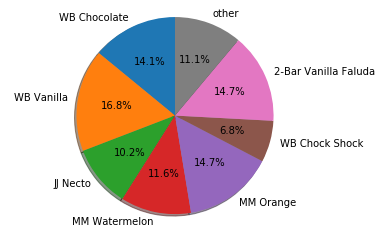

In [8]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
# sizes = [15, 30, 45, 10]
# explode = (0, 0.1, 0, 0)  # onl/y "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


In [9]:
print("Number of rows: {}".format(df.Product.count()))
df.info()

Number of rows: 441
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                441 non-null    datetime64[ns]
 1   Product             441 non-null    object        
 2   Planned start Time  441 non-null    object        
 3   Actual Start Time   441 non-null    object        
 4   Stop Time           441 non-null    object        
 5   Total time          441 non-null    float64       
 6   Startup Delay       441 non-null    float64       
 7   BreakDowns          441 non-null    float64       
 8   Eff Prod time       441 non-null    float64       
 9   Operating Speed     441 non-null    int64         
 10  Produced Qty        441 non-null    int64         
 11  Rejects Qty         441 non-null    float64       
 12  Mix Usage           441 non-null    float64       
 13  Mix Wastage         441 non-nu

In [10]:
group_by_products = df.groupby(by=['Product'])
product_data_avg = group_by_products.mean()
product_data_count = group_by_products.count()
# print(product_data_avg)
# print(product_data_count)

## Some plots using seaboarn
https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
    

### OEE vs Rejects Percentage

<Figure size 1296x432 with 0 Axes>

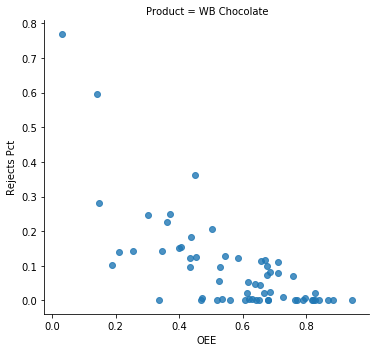

In [11]:

fig = plt.figure(figsize=(18,6))
filtered_class = df[df['Product'] == 'WB Chocolate']
sns.lmplot("OEE", "Rejects Pct", data=filtered_class, fit_reg=False, col='Product', col_wrap=2, ci=5)


## Visualize preprocessing - remove outliers

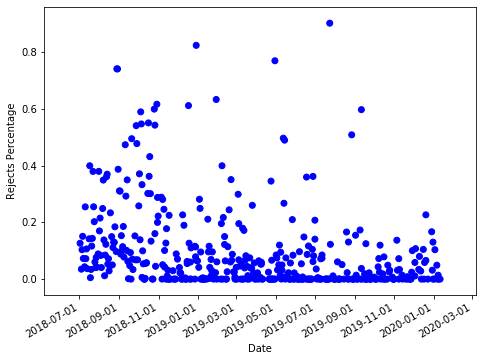

In [12]:
# Add rejects percentage
def outliers(row):
    return 'red' if row["Rejects Pct"] > 1 else 'blue'

df['color'] = df.apply (lambda row: outliers(row), axis=1)

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

x = np.asarray(df.Date)
y = np.asarray(df["Rejects Pct"])

ax.scatter(x, y, c=df['color'])
ax.set_xlabel('Date')
ax.set_ylabel('Rejects Percentage')

# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

df = df[df['color'] == 'blue']

In [13]:
df.iloc[2]

Date                  2018-07-05 00:00:00
Product                        WB Vanilla
Planned start Time               06:00:00
Actual Start Time                09:00:00
Stop Time                        18:00:00
Total time                             12
Startup Delay                           3
BreakDowns                            3.9
Eff Prod time                         5.1
Operating Speed                     28880
Produced Qty                       187410
Rejects Qty                       21656.7
Mix Usage                            7840
Mix Wastage                       812.125
Mix yield                        0.896413
AR                                  0.425
PR                                1.42338
QR                               0.896413
OEE                              0.542274
Mix Per Stick                      0.0375
Efficiency                       0.595438
Rejects Pct                      0.103587
color                                blue
Name: 2, dtype: object

/home/dulanj/Environments/py376/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


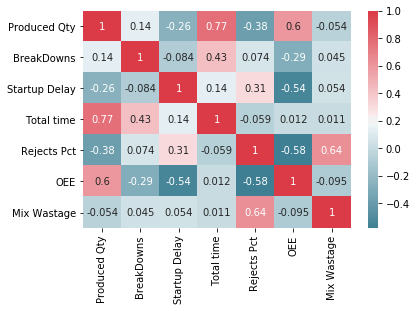

In [14]:
useful_colomns_2 = ["Product", "Produced Qty", "BreakDowns", 
                  "Startup Delay", "Total time", "Rejects Pct", "OEE", "Mix Wastage"]
df1 = df[useful_colomns_2]
df1['Produced Qty'] = df1['Produced Qty'].astype(float)
corr = df1.loc[:,df1.dtypes == 'float64'].corr()
ax = plt.axes()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, ax = ax)

#### Pairplot distributions

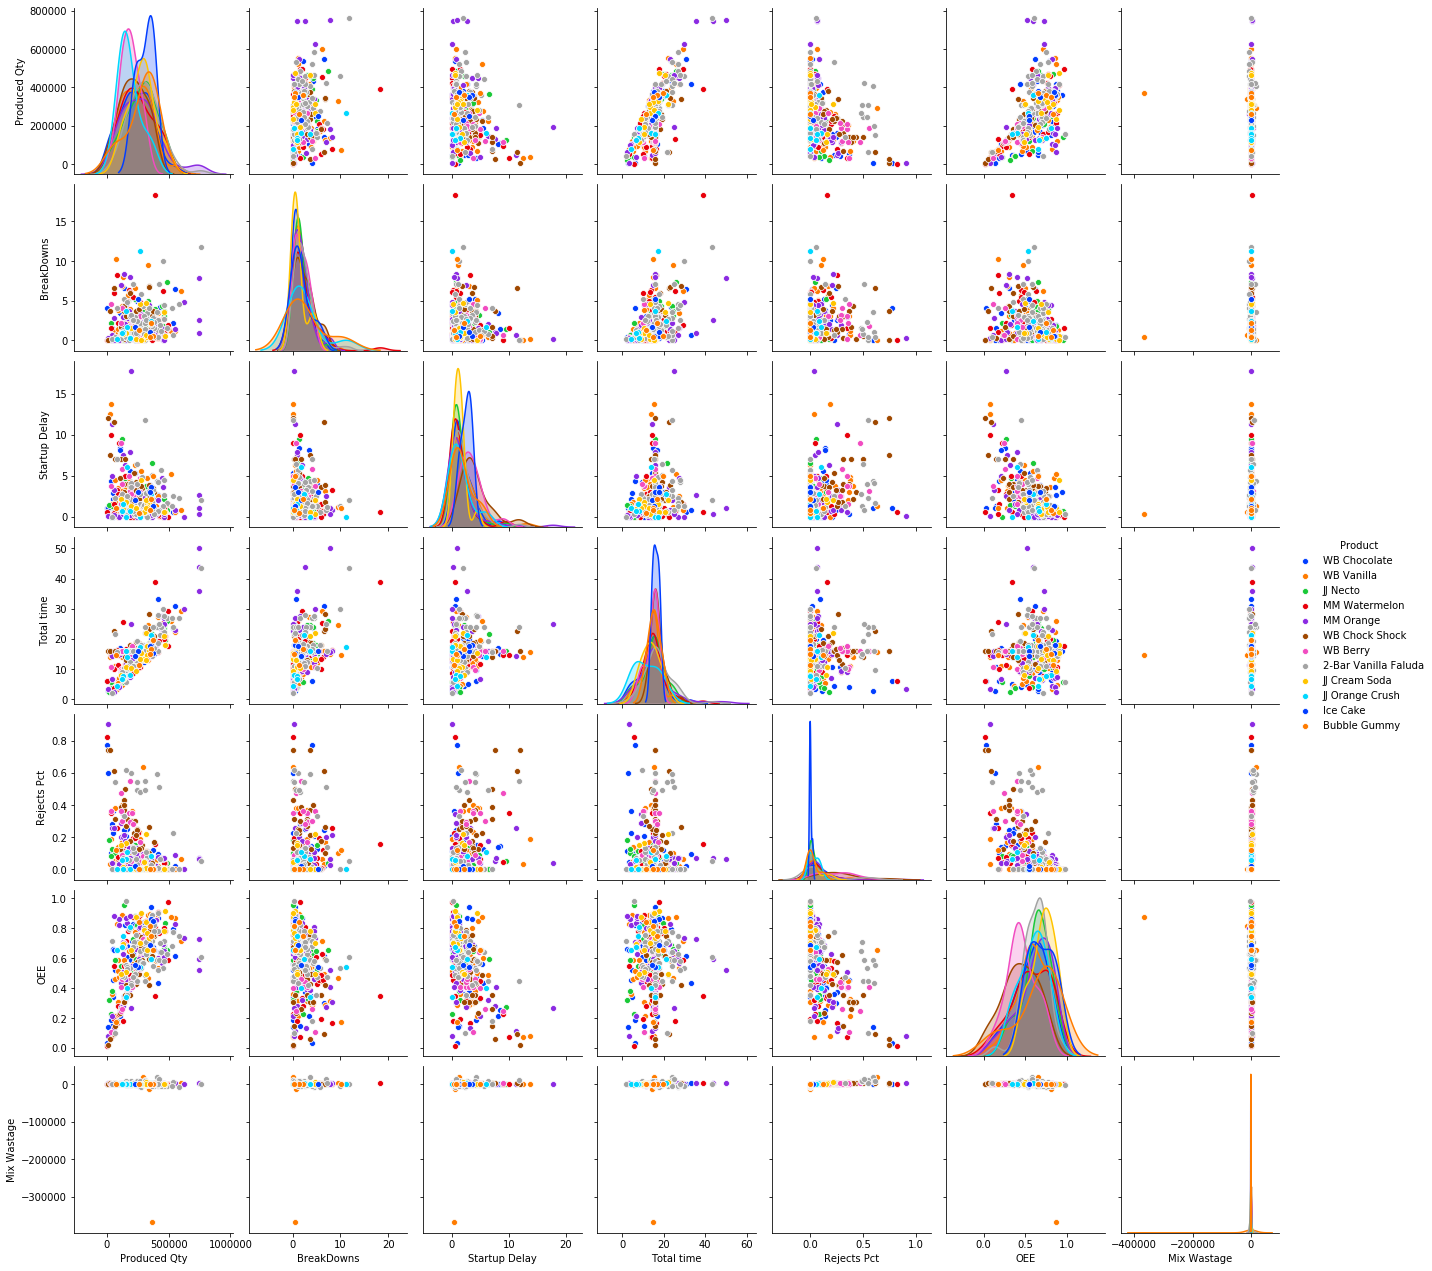

In [15]:
sns.pairplot(df1, hue="Product", palette="bright")

In [16]:
# df.info()

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

start_date = pd.to_datetime('2019-06-01')
end_date = pd.to_datetime('2019-06-30')

new_df = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]

# new_df = new_df[useful_colomns]
new_df['Produced Qty'] = new_df['Produced Qty'].astype(float)

# new_df.info()

/home/dulanj/Environments/py376/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Produced Qty   441 non-null    float64
 1   BreakDowns     441 non-null    float64
 2   Startup Delay  441 non-null    float64
 3   Rejects Qty    441 non-null    float64
dtypes: float64(4)
memory usage: 13.9 KB
None
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


Text(0.5, 0, 'Year 2019')

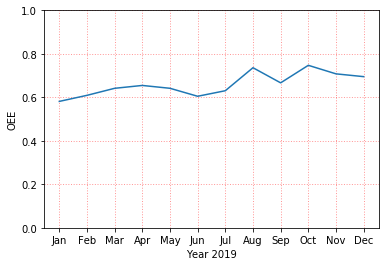

In [18]:
# Mothls average OEE
df['Date'] = pd.to_datetime(df['Date'])
avg_oee = []
avg_ar = []
avg_pr = []
avg_qr = []


useful_colomns_3 = ["Produced Qty", "BreakDowns", "Startup Delay", "Rejects Qty"]
x = df[useful_colomns_3].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_df_scaled = pd.DataFrame(x_scaled, columns = useful_colomns_3)

print(new_df_scaled.info())

avg_qty = []
avg_break = []
avg_startup = []
avg_rejects = []


months = ["%02d" % x for x in range(1,13)]
for i in months:
    try:
        start_date = pd.to_datetime('2019-{}-01'.format(i))
        end_date = pd.to_datetime('2019-{}-28'.format(i))

        new_df = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]
        df_scaled = new_df_scaled[(df['Date'] > start_date) & (df['Date'] <= end_date)]
    except (ParserError, ValueError):
        continue
    avg_oee.append(new_df['OEE'].mean())
    avg_ar.append(new_df['AR'].mean())
    avg_pr.append(new_df['PR'].mean())
    avg_qr.append(new_df['QR'].mean())
    
    avg_qty.append(df_scaled['Produced Qty'].mean())
    avg_break.append(df_scaled['BreakDowns'].mean())
    avg_startup.append(df_scaled['Startup Delay'].mean())
    avg_rejects.append(df_scaled['Rejects Qty'].mean())


x = [ calendar.month_abbr[x] for x in range(1,13)]
print(x)
plt.plot(x, avg_oee)
# plt.title("Average OEE with each month")
axes = plt.gca()
axes.set_ylim([0,1])
axes.grid(color='r', linestyle=':', linewidth=1, alpha=0.4)
axes.set_ylabel("OEE")
axes.set_xlabel("Year 2019")

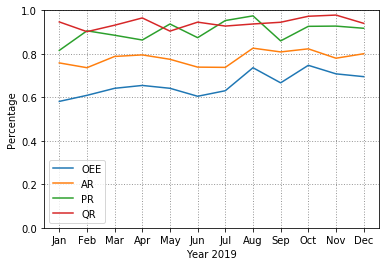

In [19]:
plt.plot(x, avg_oee, label='OEE')
plt.plot(x, avg_ar, label='AR')
plt.plot(x, avg_pr, label='PR')
plt.plot(x, avg_qr, label='QR')
# plt.title("Average AR,PR,QR and OEE variation with each month")
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlabel("Year 2019")
axes.set_ylabel("Percentage")
axes.legend()
axes.grid(color='black', linestyle=':', linewidth=1, alpha=0.4)

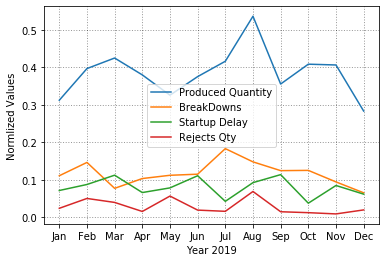

In [20]:
plt.plot(x, avg_qty, label='Produced Quantity')
plt.plot(x, avg_break, label='BreakDowns')
plt.plot(x, avg_startup, label='Startup Delay')
plt.plot(x, avg_rejects, label='Rejects Qty')
# plt.title("Average AR,PR,QR and OEE variation with each month")
axes = plt.gca()
# axes.set_ylim([0,1])
axes.set_xlabel("Year 2019")
axes.set_ylabel("Normlized Values")
axes.legend()
axes.grid(color='black', linestyle=':', linewidth=1, alpha=0.4)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']


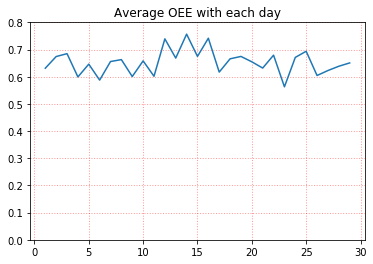

In [21]:
# Daily Average
# Mothls average OEE


df['Date'] = pd.to_datetime(df['Date'])
avg_oee = []
avg_ar = []
avg_pr = []
avg_qr = []
days = ["%02d" % x for x in range(1,31)]
months = ["%02d" % x for x in range(1,13)]
print(days)
for i, d in enumerate(days[:-1]):
    new_df = pd.DataFrame()
    for m in months:
        try:
            start_date = pd.to_datetime('2019-{}-{}'.format(m, d))
            end_date = pd.to_datetime('2019-{}-{}'.format(m, days[i+1]))
            temp_df = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]
        except (ParserError, ValueError):
            continue
        frames = [new_df, temp_df]

        new_df = pd.concat(frames)

    avg_oee.append(new_df['OEE'].mean())
    avg_ar.append(new_df['AR'].mean())
    avg_pr.append(new_df['PR'].mean())
    avg_qr.append(new_df['QR'].mean())

# print(avg_oee)
x_days = [x for x in range(1,30)] 
plt.plot(x_days, avg_oee)
plt.title("Average OEE with each day")
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0,0.8])
axes.grid(color='r', linestyle=':', linewidth=1, alpha=0.4)

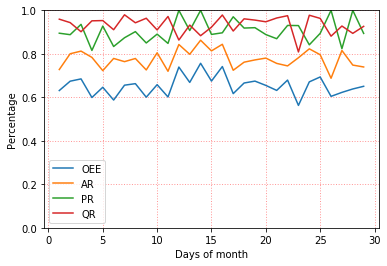

In [22]:
plt.plot(x_days, avg_oee, label='OEE')
plt.plot(x_days, avg_ar, label='AR')
avg_pr = [ pr if pr <=1 else 1 for pr in avg_pr]
plt.plot(x_days, avg_pr, label='PR')
plt.plot(x_days, avg_qr, label='QR')
# plt.title("Average AR,PR,QR and OEE variation with each day")
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_ylabel("Percentage")
axes.set_xlabel("Days of month")
axes.legend()
axes.grid(color='r', linestyle=':', linewidth=1, alpha=0.4)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
[0.33333333 0.33333333 0.58333333 0.25       0.08333333 1.
 0.41666667 2.5        0.25       1.5        2.33333333 0.25
 0.5        0.5        0.5        0.08333333 0.21666667 1.16666667]
[ 1  2  4  6  8  9 10 13 14 15 16 17 20 21 23 24 28 29]


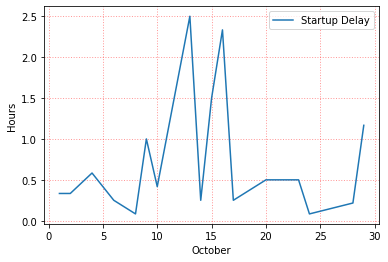

In [23]:
# Startup delay
df['Date'] = pd.to_datetime(df['Date'])
avg_oee = []
avg_ar = []
avg_pr = []
avg_qr = []
sum_delay=[]
days = ["%02d" % x for x in range(1,31)]
months = ["%02d" % x for x in range(1,13)]
print(days)
for i, d in enumerate(days[:-1]):
    try:
        start_date = pd.to_datetime('2019-10-{}'.format(d))
        end_date = pd.to_datetime('2019-10-{}'.format(days[i+1]))
        temp_df = df[(df['Date'] > start_date) & (df['Date'] <= end_date)]
    except (ParserError, ValueError):
        continue
#     print(temp_df["Startup Delay"])
#     print(temp_df["Startup Delay"].count())
    sum_delay.append(temp_df["Startup Delay"].sum())

# print(sum_delay)
x_days = np.array([x for x in range(1,31)] )
sum_delay = np.array(sum_delay)
x_days = x_days[np.where(sum_delay != 0)]
sum_delay = np.delete(sum_delay, np.where(sum_delay == 0))
print(sum_delay)
print(x_days)
plt.plot(x_days, sum_delay, label="Startup Delay")
# plt.title("Startup delay each day in Octobor")
axes = plt.gca()
axes.set_xlabel("October")
axes.set_ylabel("Hours")
axes.legend()
axes.grid(color='r', linestyle=':', linewidth=1, alpha=0.4)
# plt.xticks(x_days)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# axes = plt.gca()
# axes.set_ylim([0,0.8])

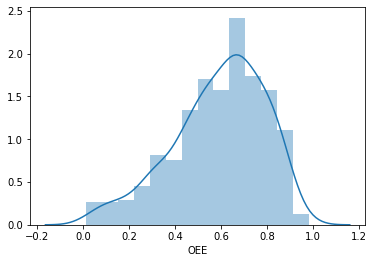

In [24]:
sns.distplot(df["OEE"])
axes.grid(color='r', linestyle=':', linewidth=1, alpha=0.4)

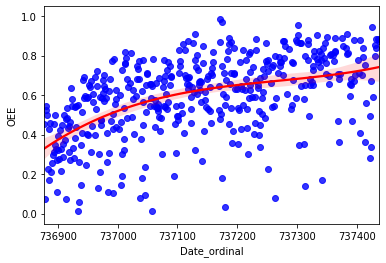

In [25]:
df['Date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
plt.figure(figsize=(6,4))
sns.regplot(x='Date_ordinal',y='OEE',data=df, fit_reg=True, order = 3,
            scatter_kws = {'color': 'b'}, line_kws = {'color': 'red'}) 

<Figure size 2160x2160 with 0 Axes>

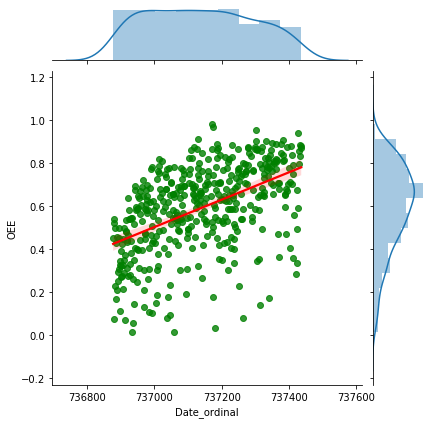

In [26]:
plt.figure(figsize=(30,30))
sns.jointplot(x="Date_ordinal", y="OEE", data=df, kind='reg', 
              scatter_kws = {'color': 'g'}, line_kws = {'color': 'red'})

# plt.xlabel('test')
# plt.ylabel('Function Throughput')

In [27]:
# ax = sns.scatterplot(x="Date", y="Rejects Pct", hue="color", data=df)
# df = df.drop(["color"], axis = 1)

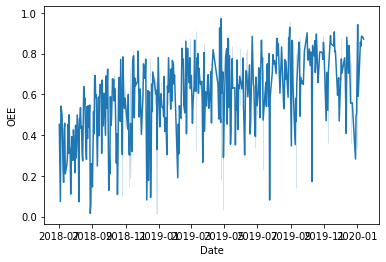

In [28]:
ax = sns.lineplot(x="Date", y="OEE", data=df)

In [29]:
# sns.lmplot(x="Date", y='OEE', data=df, ci=None)

In [30]:
# fig=plt.figure()
# ax=fig.add_axes([0,0,1,1])

# x = np.asarray(df.Date)
# y = np.asarray(df["OEE"])

# ax.scatter(x, y)
# ax.set_xlabel('Time')
# ax.set_ylabel('OEE')

# # format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
# import matplotlib.dates as mdates
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# # rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# fig.plot(x,p(x),"r--")

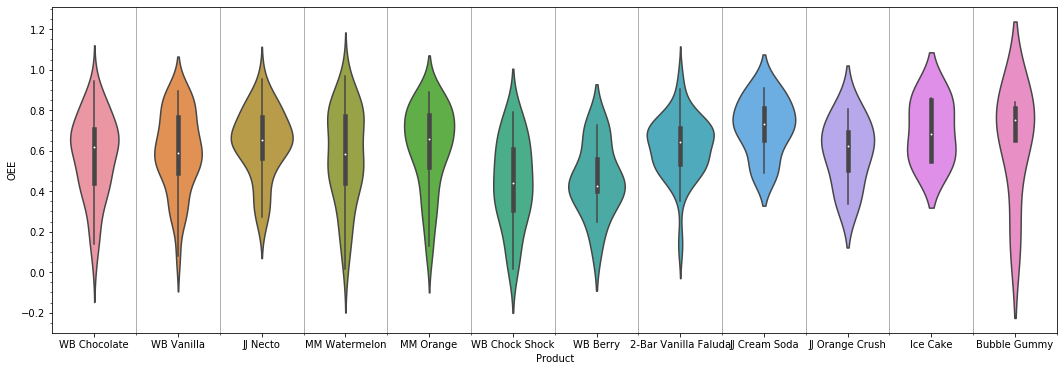

In [31]:


fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot('Product', "OEE", data=df)


ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

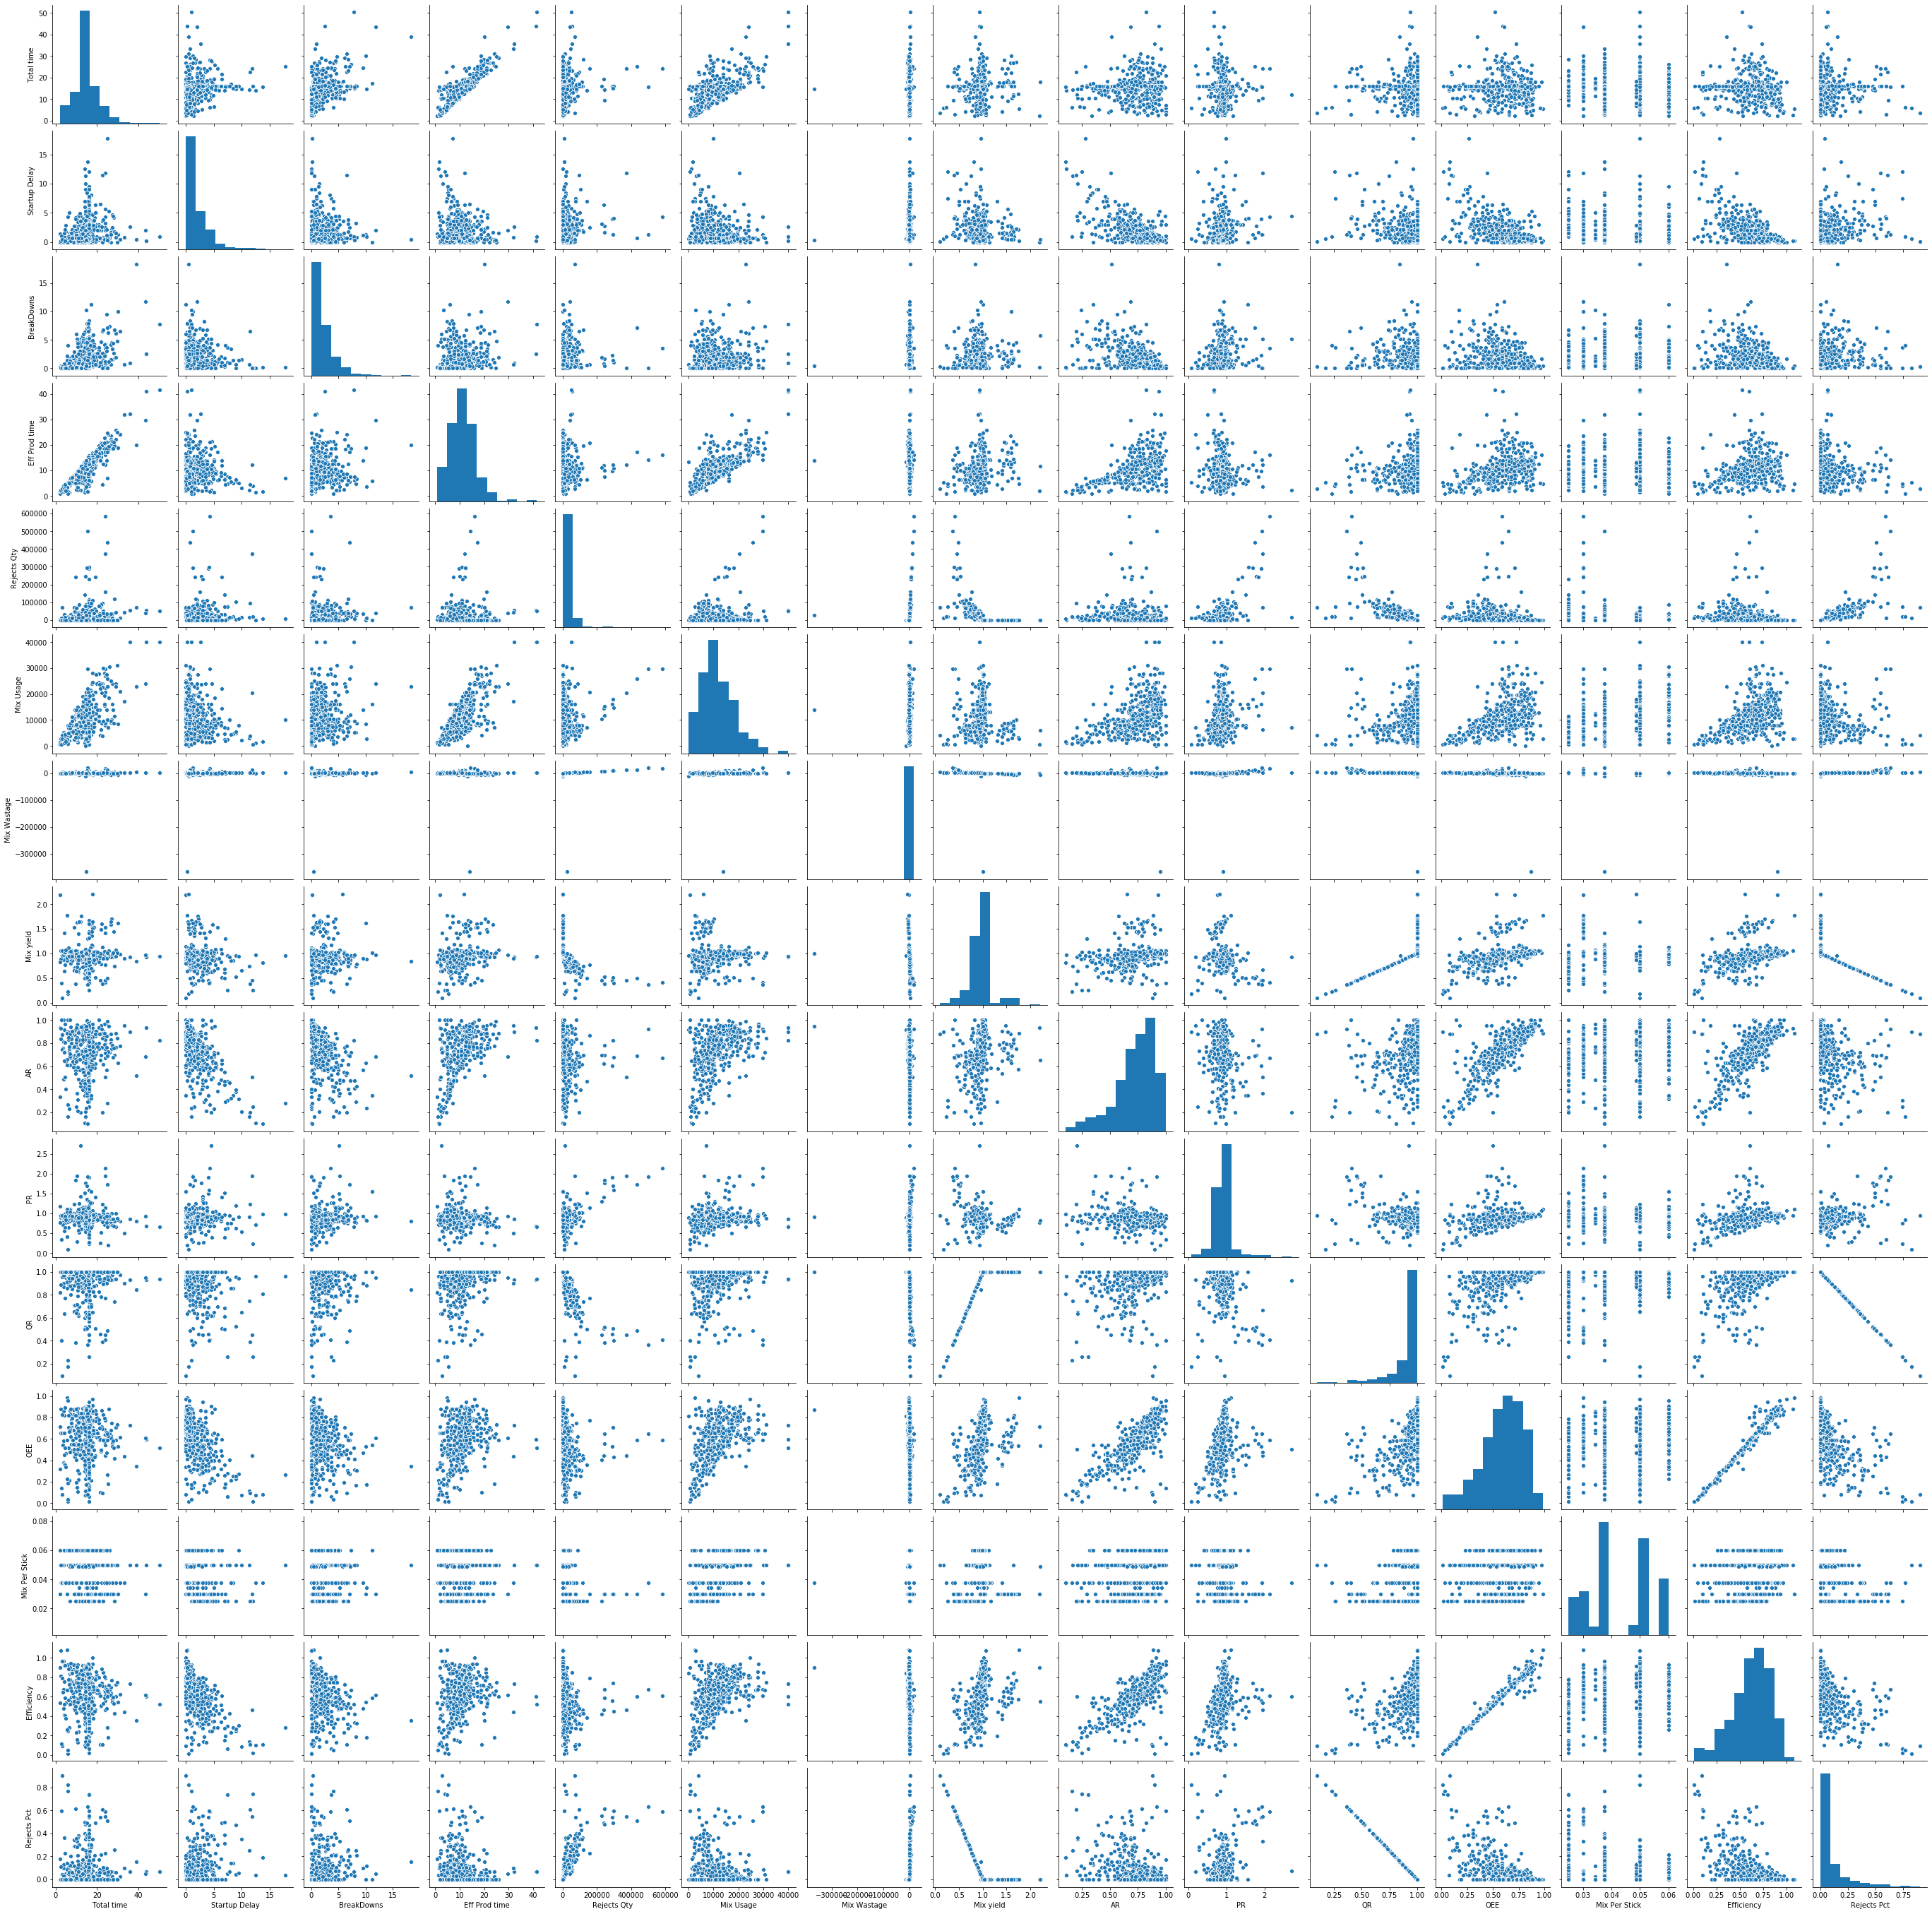

In [32]:
sns.pairplot(df.loc[:,df.dtypes == 'float64'])

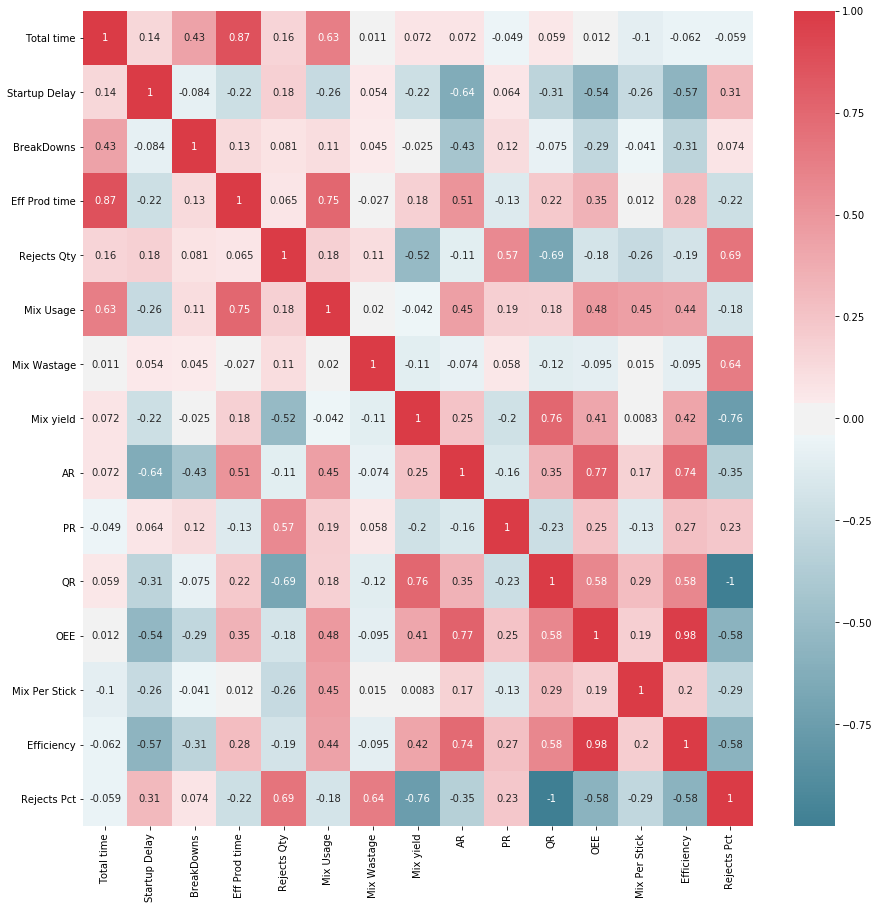

In [33]:
corr = df.loc[:,df.dtypes == 'float64'].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

In [34]:
for col in df.columns.values:
    print("{:20} = {}".format(col, df[col].nunique()))

Date                 = 390
Product              = 12
Planned start Time   = 151
Actual Start Time    = 224
Stop Time            = 218
Total time           = 208
Startup Delay        = 130
BreakDowns           = 261
Eff Prod time        = 386
Operating Speed      = 5
Produced Qty         = 433
Rejects Qty          = 297
Mix Usage            = 253
Mix Wastage          = 435
Mix yield            = 439
AR                   = 431
PR                   = 436
QR                   = 300
OEE                  = 439
Mix Per Stick        = 7
Efficiency           = 441
Rejects Pct          = 300
color                = 1
Date_ordinal         = 390


In [35]:
import numpy as np
print(np.min(df["Efficiency"]))
print(np.max(df["Efficiency"]))
print(np.average(df["Efficiency"]))
print(np.var(df["Efficiency"]))

0.0144463293667572
1.08422471300031
0.6174142201712173
0.041447896769146904


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa68ca9f1d0>]],
      dtype=object)

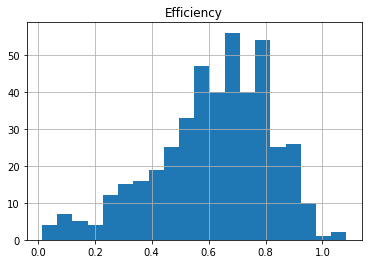

In [36]:
df.hist(bins=20, column="Efficiency")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa68ca5bb50>,
      dtype=object)

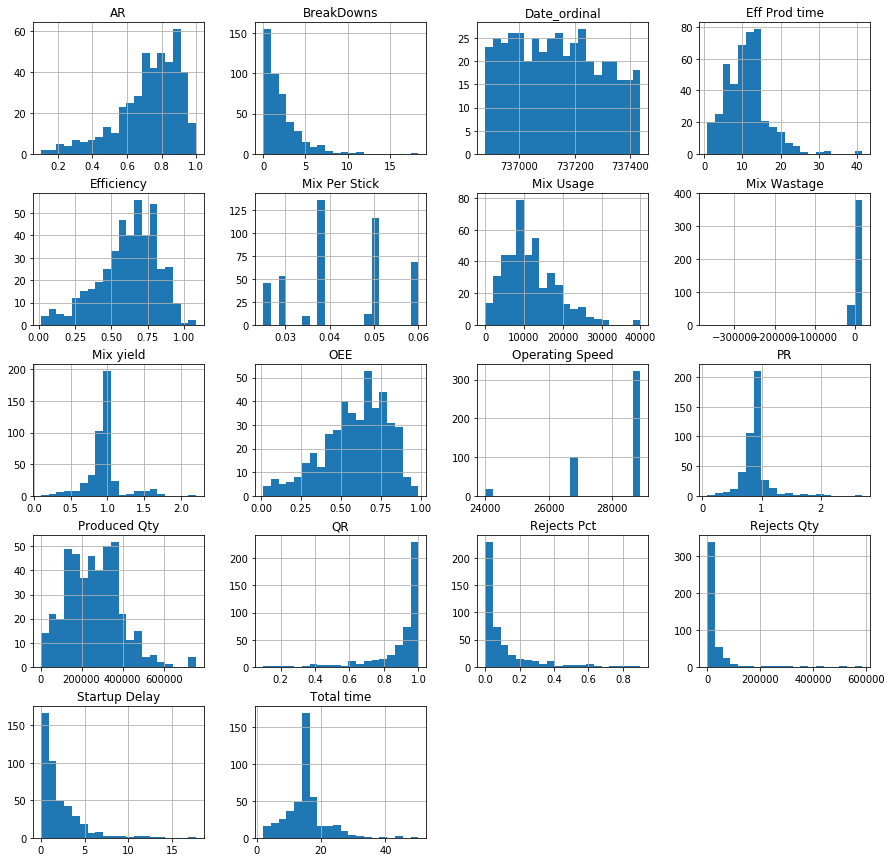

In [37]:
df.hist(bins=20, figsize=(15,15))